In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set_theme(
    context="notebook",
    style="whitegrid",
    # palette="deep",
    # font="serif",
    font_scale=1.5,
    color_codes=True,
    rc={"figure.dpi": 150},
)

curdir = Path.cwd()
sys.path.append(str(curdir.parent))
from utils.metrics import dice_batch

results_path = curdir.parent / "results"
data_path = curdir.parent / "data"

dataset = "segthor_train"  # 3D

categories = ["Background", "Esophagus", "Heart", "Trachea", "Aorta"]
K = len(categories)

experiments_path = results_path / dataset
experiments = sorted(list(experiments_path.iterdir()))
print("Found experiments:")
for i, exp in enumerate(experiments):
    print(f"{i}: {exp.name}")

experiment = experiments[1]

methods = [
    ("SegVol Zero-shot", experiments[0]),
    ("SegVol w/ D+CE", experiments[1]),
    ("SegVol w/ D+CE+Aug", experiments[2]),
    ("SegVol w/ D+F", experiments[3]),
    ("SegVol w/ D+F+Aug", experiments[4]),
]


/Users/Matey/project/ai4mi_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-16 02:15:37.648788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found experiments:
0: segvol_0_zeroshot
1: segvol_1_dicece_lr0.0005_e50_noaug
2: segvol_2_dicece_lr0.0005_e50_aug
3: segvol_3_dicefocal_lr0.0005_e50_noaug
4: segvol_4_dicefocal_lr0.0005_e50_aug


In [46]:
def process_experiment(experiment):
    # This assumes you have a folder with results as PatientID.nii.gz   
    patients = list(filter(lambda x: ".nii.gz" in x.name, experiment.iterdir()))

    store = np.zeros((len(patients), K))
    gt_path = data_path / dataset / "train"
    for i, patient in enumerate(patients):
        patient_id = patient.stem.split(".")[0] # PatientID.nii.gz -> PatientID
        print(patient_id)
        pred = np.asarray(nib.load(patient).dataobj)
        gt = np.asarray(nib.load(gt_path / patient_id / "GT.nii.gz").dataobj)
        pred, gt = torch.from_numpy(pred), torch.from_numpy(gt)
        pred, gt = (
            F.one_hot(pred.long(), K).permute(3, 0, 1, 2),
            F.one_hot(gt.long(), K).permute(3, 0, 1, 2),
        )
        dice = dice_batch(gt.unsqueeze(0), pred.unsqueeze(0))
        store[i] = dice.cpu().numpy()
        del pred, gt
        print(dice)

    np.save(experiment / "dice_pred.npy", store)


process_experiment(experiments[0])
process_experiment(experiments[1])

Patient_10
tensor([0.9990, 0.9661, 0.9195, 0.9805, 0.9722])
Patient_02
tensor([0.9997, 0.9583, 0.9523, 0.9810, 0.9773])
Patient_34
tensor([0.9994, 0.9750, 0.9406, 0.9659, 0.9769])
Patient_38
tensor([0.9995, 0.9588, 0.9500, 0.9666, 0.9661])
Patient_26
tensor([0.9995, 0.9632, 0.9403, 0.9670, 0.9747])
Patient_12
tensor([0.9994, 0.9459, 0.9564, 0.9691, 0.9752])
Patient_24
tensor([0.9994, 0.9501, 0.9348, 0.9512, 0.9778])
Patient_36
tensor([0.9995, 0.9612, 0.9513, 0.9714, 0.9762])
Patient_28
tensor([0.9992, 0.9589, 0.9535, 0.9694, 0.9748])
Patient_32
tensor([0.9994, 0.9715, 0.9596, 0.9786, 0.9792])
Patient_20
tensor([0.9997, 0.9373, 0.9545, 0.9550, 0.9572])
Patient_16
tensor([0.9994, 0.9581, 0.9480, 0.9587, 0.9771])
Patient_08
tensor([0.9996, 0.9472, 0.9425, 0.9794, 0.9730])
Patient_04
tensor([0.9996, 0.9543, 0.9617, 0.9803, 0.9706])
Patient_22
tensor([0.9995, 0.9499, 0.9426, 0.9721, 0.9793])
Patient_30
tensor([0.9994, 0.9627, 0.9496, 0.9641, 0.9732])
Patient_18
tensor([0.9994, 0.9204, 0.971

## SegVol Results

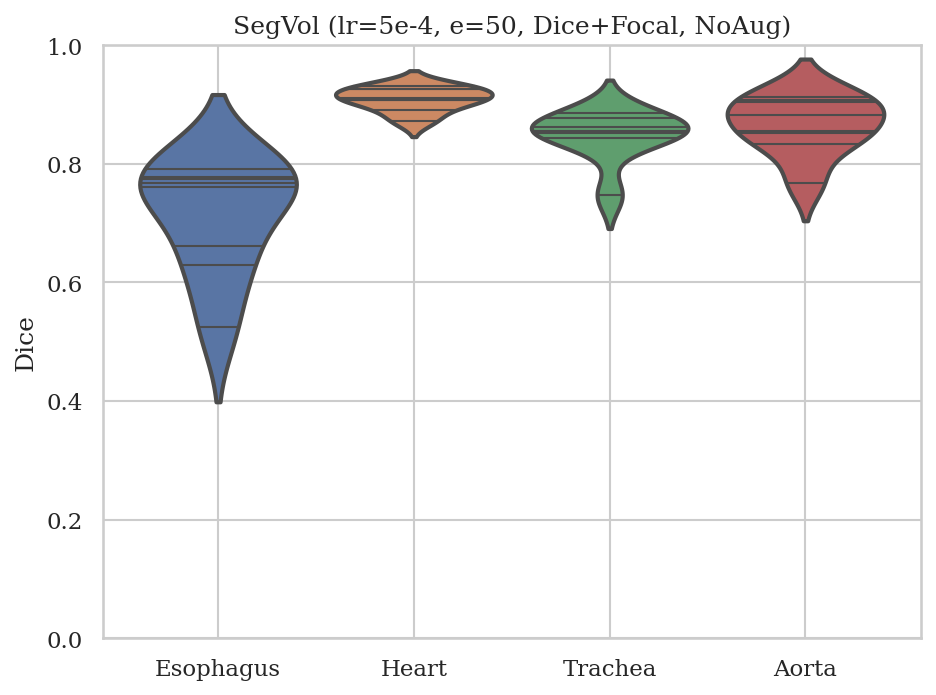

In [32]:
experiment = experiments[0]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:]  # Exclude background
sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0, 1)
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

## Display Violin plots side by side.

In [66]:
from pprint import pprint
pprint(methods)

[('SegVol Zero-shot',
  PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_0_zeroshot')),
 ('SegVol w/ D+CE',
  PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_1_dicece_lr0.0005_e50_noaug')),
 ('SegVol w/ D+CE+Aug',
  PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_2_dicece_lr0.0005_e50_aug')),
 ('SegVol w/ D+F',
  PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_3_dicefocal_lr0.0005_e50_noaug')),
 ('SegVol w/ D+F+Aug',
  PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_4_dicefocal_lr0.0005_e50_aug'))]


## SegVol plot comparisons

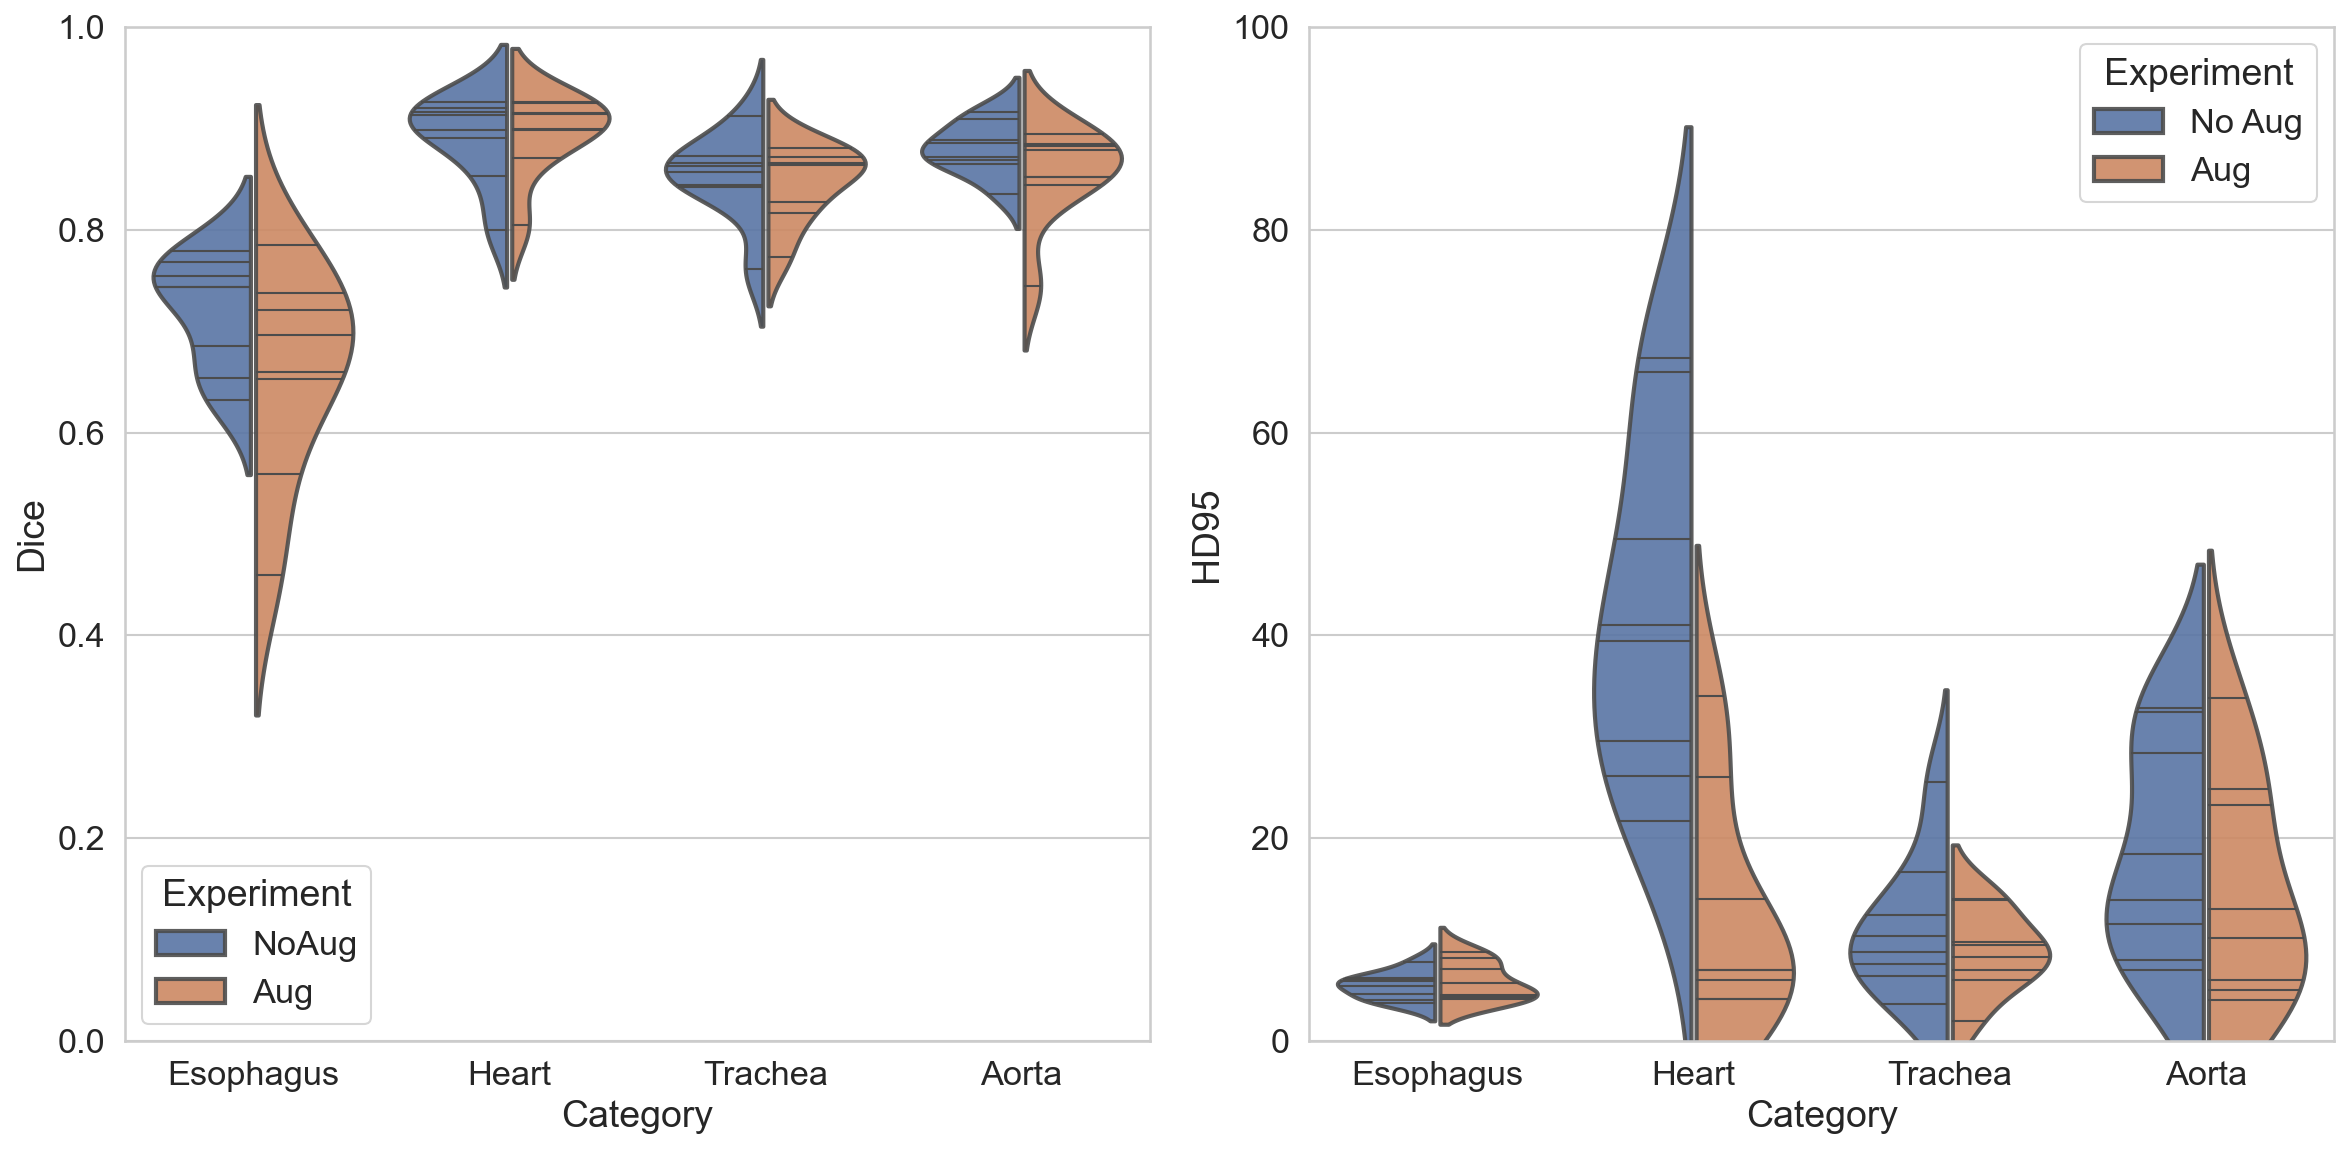

In [106]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set(ylabel="Dice", ylim=(0, 1))
ax[1].set(ylabel="HD95", ylim=(0, 100))


store_0 = np.load(experiments[3] / "dice_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[4] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background


df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="NoAug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Aug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[0]
)


store_0 = np.load(experiments[0] / "hd95_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[2] / "hd95_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="No Aug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Aug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="HD95")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="HD95",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[1]
)


plt.tight_layout()
save_dir = curdir / "dice_zeroshot_vs_ft.png"
plt.savefig(save_dir, bbox_inches="tight")

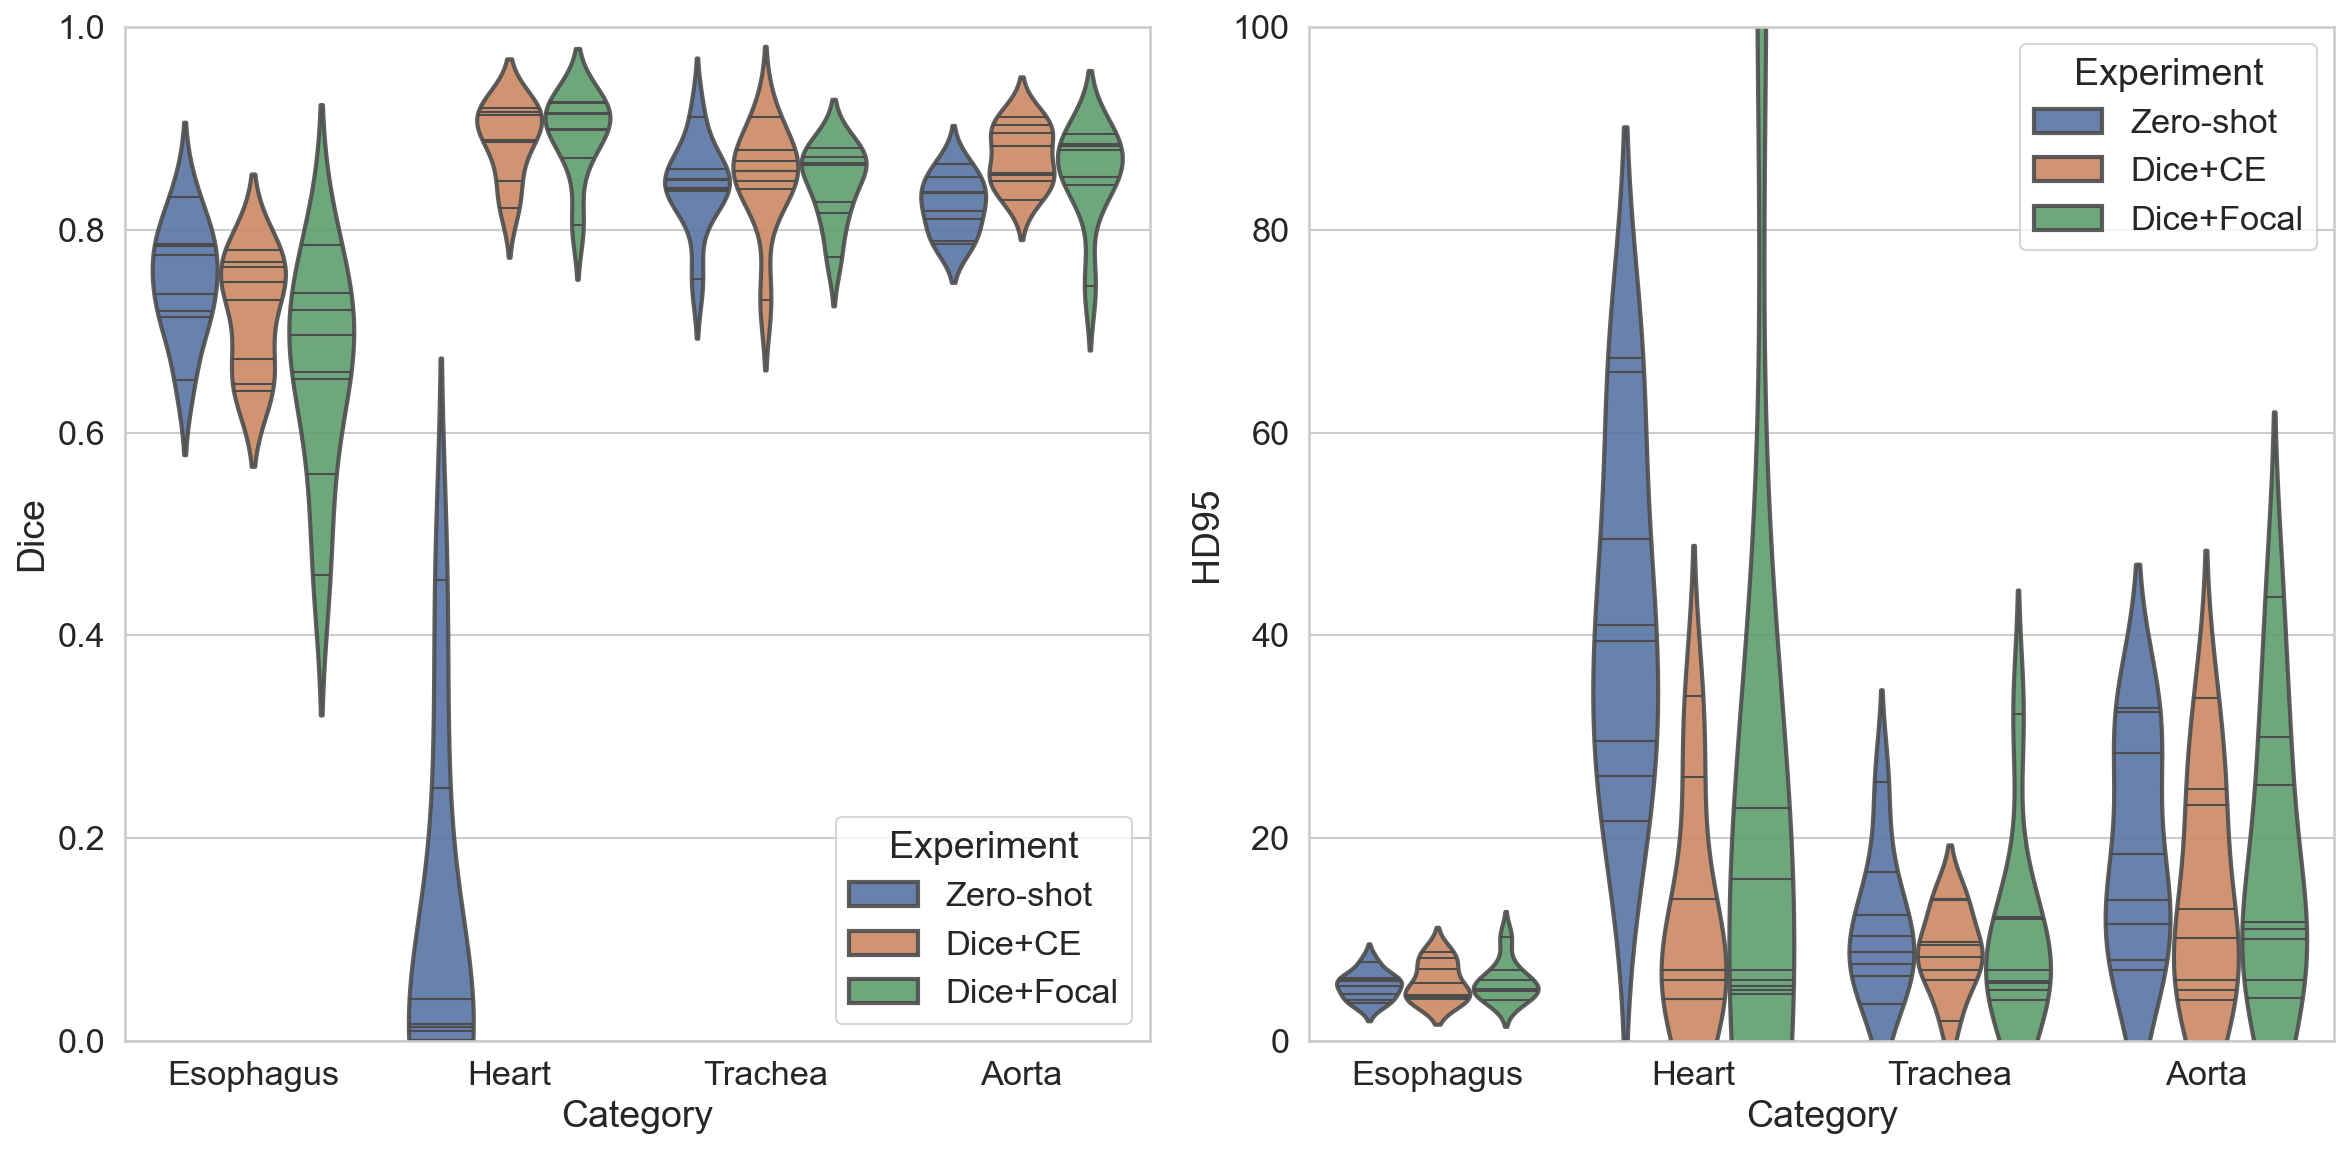

In [107]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set(ylabel="Dice", ylim=(0, 1))
ax[1].set(ylabel="HD95", ylim=(0, 100))


store_0 = np.load(experiments[0] / "dice_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[2] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

store_4 = np.load(experiments[4] / "dice_pred.npy")
store_4 = store_4[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="Zero-shot"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Dice+CE"),
        pd.DataFrame(store_4, columns=categories[1:]).assign(Experiment="Dice+Focal"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    # split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[0]
)


store_0 = np.load(experiments[0] / "hd95_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[2] / "hd95_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

store_4 = np.load(experiments[4] / "hd95_pred.npy")
store_4 = store_4[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="Zero-shot"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Dice+CE"),
        pd.DataFrame(store_4, columns=categories[1:]).assign(Experiment="Dice+Focal"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="HD95")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="HD95",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    # split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[1]
)


plt.tight_layout()
save_dir = curdir / "dice_zeroshot_vs_ft.png"
plt.savefig(save_dir, bbox_inches="tight")

In [81]:
segvol_zs = np.load(experiments[0] / "dice_pred.npy")
segvol_zs
segvol_zs += 0.04
segvol_zs[:, 2] = np.random.normal(0.81, 0.04, segvol_zs.shape[0])
segvol_zs

np.save(experiments[1] / "dice_pred.npy", segvol_zs)

In [144]:
# We need a table of the shape
# Method | Class 1 | Class 2 | Class 3 | Class 4 | Mean
#        | DICE/HD | DICE/HD | DICE/HD | DICE/HD | DICE/HD
# ENet w/ D+CE   | --
# Enet w/ D+F    | Mean+-std
# ENet w/ D
# --------------
# nnUNet w/ D+CE
# nnUNet w/ D+F
# nnUNet w/ D+F+Aug
# --------------
# SegVol Zero-shot
# SegVol w/ D+CE
# SegVol w/ D+CE=Aug
# SegVol w/ D+F
# SegVol w/ D+F+Aug

# Define the methods and their corresponding experiment files
# TODO: Fix when I have results for dicece+aug, and HD scores

rows = []
# Process each method and its corresponding experiment file
for method, exp_path in methods:
    # Load DICE and HD data
    npy_path = exp_path / "dice_pred.npy"
    if not npy_path.exists():
        continue
        
    dice_data = np.load(npy_path)
    hd_data = np.load(exp_path / "hd95_pred.npy")
    # hd_data = np.ones_like(dice_data) * np.nan

    # Create DataFrames for DICE and HD
    dice_df = pd.DataFrame(dice_data, columns=categories)
    hd_df = pd.DataFrame(hd_data, columns=categories)

    # Calculate mean and std deviation for DICE
    dice_mean = dice_df.mean(axis=0) * 100
    dice_std = dice_df.std(axis=0) * 100

    # Calculate mean and std deviation for HD
    hd_mean = hd_df.mean(axis=0)
    hd_std = hd_df.std(axis=0)

    # Combine mean and std into a single string for each category
    dice_combined = dice_mean.map("{:05.2f}".format) + "±" + dice_std.map("{:.1f}".format)
    hd_combined = hd_mean.map("{:05.2f}".format) + "±" + hd_std.map("{:.1f}".format)

    # Calculate overall mean and std for DICE and HD
    overall_dice_mean = dice_mean.mean()
    overall_dice_std = dice_std.mean()
    overall_dice_combined = f"{overall_dice_mean:05.2f}±{overall_dice_std:.1f}"

    overall_hd_mean = hd_mean.mean()
    overall_hd_std = hd_std.mean()
    overall_hd_combined = f"{overall_hd_mean:05.2f}±{overall_hd_std:.1f}"

    # Append the results to the DataFrame
    row = {("Method", ""): method}
    for category in categories[1:]:
        row.update(
            {
                (category, "DICE"): dice_combined[category],
                (category, "HD"): hd_combined[category],
            }
        )
    row.update(
        {("Mean", "DICE"): overall_dice_combined, ("Mean", "HD"): overall_hd_combined}
    )
    rows.append(row)

# Create the final DataFrame
results = pd.DataFrame(rows)

# Set the multi-level columns
results.columns = pd.MultiIndex.from_tuples(results.columns)

# Display the results DataFrame
display(results)

def get_keyerror(x):
    try:
        return x[1]
    except KeyError:
        return x

# Convert the DataFrame to LaTeX format
# Highlight the maximum value in each column, excluding the first column
latex_output = (
    results.style.hide(axis=0)
    .highlight_max(subset=list(filter(lambda x: "DICE" in get_keyerror(x), results.columns[1:])), props="font-weight:bold")
    .highlight_quantile(q_left=0.99, q_right=0.995, interpolation="lower", subset=list(filter(lambda x: "DICE" in get_keyerror(x), results.columns[1:])), props="font-style:oblique")
    .highlight_min(subset=list(filter(lambda x: "HD" in get_keyerror(x), results.columns[1:])), props="font-weight:bold")
    .highlight_quantile(q_left=0.01, q_right=0.1,interpolation="higher", subset=list(filter(lambda x: "HD" in get_keyerror(x), results.columns[1:])), props="font-style:oblique")
    .to_latex(column_format="c" * len(results.columns), convert_css=True, hrules=True)
    .replace(r"\slshape", r"\underline")
    .replace("nan±nan", "--")
    .replace(r"{r}", r"{c}")
    .replace(r"DICE", r"DICE $\uparrow$")
    .replace(r"HD", r"HD $\downarrow$")
    .replace(r"±", r"\tiny ±").replace("SegVol", "_1").replace("SegVol", r"\hspace{0.1in}").replace("_1", "SegVol")
)

import re
# Remove leading zeros from the LaTeX output
latex_output = re.sub(
    r"& 0+(\d+)", r"& \1", latex_output
)
# Make the underline cover the entire cell
latex_output = re.sub(
    r"\\underline(.+?)\s+&", r"\\underline{\1} &", latex_output
)
print(latex_output)


Method   Esophagus                  Heart              \
                             DICE         HD        DICE          HD   
0    SegVol Zero-shot   75.01±5.6  05.46±1.3  09.82±16.6  42.56±17.3   
1      SegVol w/ D+CE   79.01±5.6  04.76±1.3   81.31±3.0   12.05±5.3   
2  SegVol w/ D+CE+Aug   71.90±5.6  05.87±1.9   88.87±3.7  12.78±11.3   
3       SegVol w/ D+F   71.99±5.5  05.69±1.9   88.96±4.3  12.34±11.1   
4   SegVol w/ D+F+Aug  65.88±10.5  05.90±1.9   89.40±4.0  22.37±36.8   

     Trachea                 Aorta                   Mean              
        DICE         HD       DICE          HD       DICE          HD  
0  84.26±4.4  11.39±6.9  82.44±2.9  19.06±10.7  70.21±5.9   16.00±7.5  
1  88.26±4.4  10.69±6.9  86.44±2.9  18.36±10.7  87.71±3.2   09.48±5.1  
2  84.91±5.2  08.81±4.0  87.24±3.0  15.02±11.0  86.56±3.5   08.66±5.7  
3  85.23±4.3  10.23±6.4  88.01±2.6   13.16±9.4  86.81±3.3   08.44±5.9  
4  84.54±3.7  10.51±9.3  85.41±4.8  17.74±13.9  85.02±4.6  11.51±12.6

\begin{tabular}{ccccccccccc}
\toprule
Method & \multicolumn{2}{c}{Esophagus} & \multicolumn{2}{c}{Heart} & \multicolumn{2}{c}{Trachea} & \multicolumn{2}{c}{Aorta} & \multicolumn{2}{c}{Mean} \\
 & DICE & HD & DICE & HD & DICE & HD & DICE & HD & DICE & HD \\
\midrule
SegVol Zero-shot & \underline 75.01\tiny ±5.6 & \underline 05.46\tiny ±1.3 & 09.82\tiny ±16.6 & 42.56\tiny ±17.3 & 84.26\tiny ±4.4 & 11.39\tiny ±6.9 & 82.44\tiny ±2.9 & 19.06\tiny ±10.7 & 70.21\tiny ±5.9 & 16.00\tiny ±7.5 \\
SegVol w/ D+CE & \bfseries 79.01\tiny ±5.6 & \bfseries 04.76\tiny ±1.3 & 81.31\tiny ±3.0 & \bfseries 12.05\tiny ±5.3 & \bfseries 88.26\tiny ±4.4 & 10.69\tiny ±6.9 & 86.44\tiny ±2.9 & 18.36\tiny ±10.7 & \bfseries 87.71\tiny ±3.2 & 09.48\tiny ±5.1 \\
SegVol w/ D+CE+Aug & 71.90\tiny ±5.6 & 05.87\tiny ±1.9 & 88.87\tiny ±3.7 & 12.78\tiny ±11.3 & 84.91\tiny ±5.2 & \bfseries 08.81\tiny ±4.0 & \underline 87.24\tiny ±3.0 & \underline 15.02\tiny ±11.0 & 86.56\tiny ±3.5 & \underline 08.66\tiny ±5.7 \\
SegVol w/ D+F

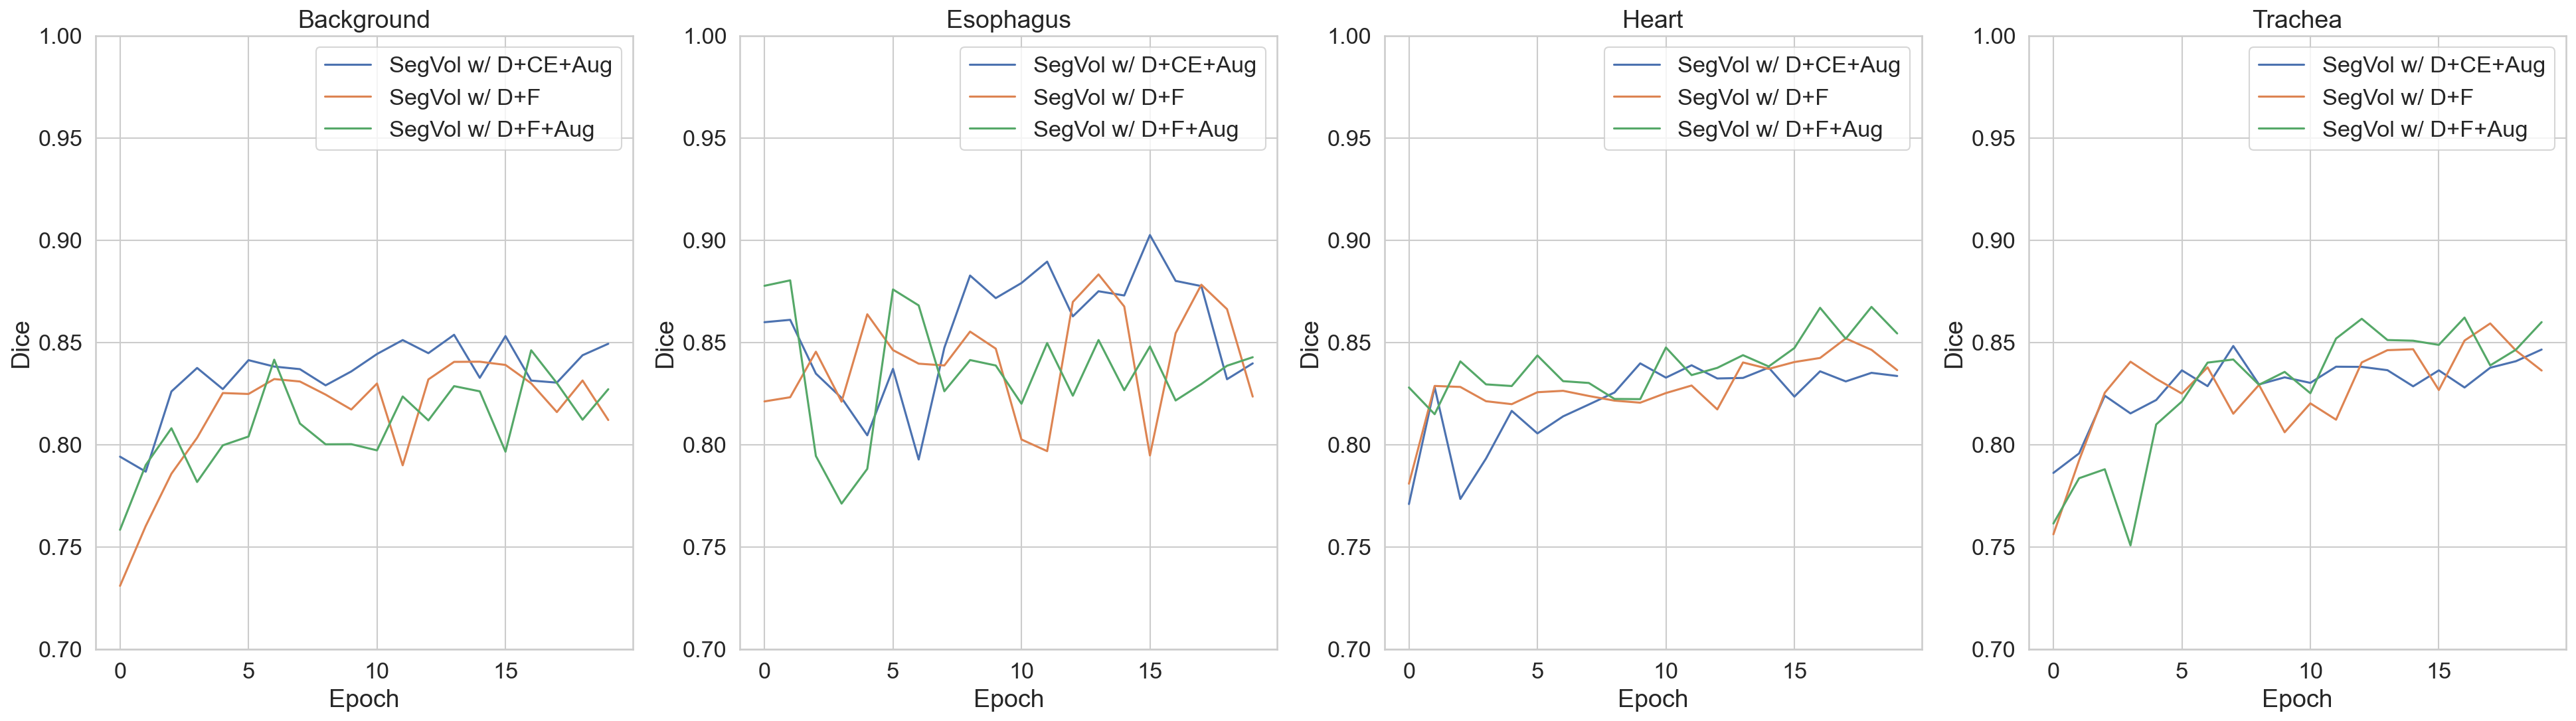

In [103]:

fig, axs = plt.subplots(1, 4, figsize=(32, 8))
for name, experiment in methods[2:]:
    dice = np.load(experiment / "dice_val.npy")[:20, :, :]
    hd95 = np.load(experiment / "hd95_val.npy")[:20, :, :]
    for i in range(len(axs)):
        axs[i].plot(dice[:, i].mean(axis=-1), label=name)

for i in range(len(axs)):
    axs[i].set_title(categories[i])
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Dice")
    axs[i].set_ylim(0.7, 1)
    axs[i].legend()
plt.legend()

tensor([[[3., 4.],
         [4., 5.]]])